<a href="https://colab.research.google.com/github/rafael2673/AEDII/blob/main/U1T5/trabalho5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalando osmnx

In [ ]:
!pip install osmnx

Começando as análises


# 1. Obtenha o grafo de bicicleta ao redor da UFRN, considerando os bairros próximos

In [ ]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

place = [
    "Nova Descoberta, Natal, Brazil",
    "Lagoa Nova, Natal, Brazil",
    "Capim Macio, Natal, Brazil",
    "Candelária, Natal, Brazil"
]
G = ox.graph_from_place(place, network_type='bike')

# 2. Calcule as métricas de centralidade

In [ ]:
degree_centrality = nx.degree_centrality(G)

In [ ]:
closeness_centrality = nx.closeness_centrality(G)

In [ ]:
betweenness_centrality = nx.betweenness_centrality(G, normalized=True)

# 3. Atribuir as métricas ao grafo

In [ ]:
nx.set_node_attributes(G, degree_centrality, 'degree_centrality')
nx.set_node_attributes(G, closeness_centrality, 'closeness_centrality')
nx.set_node_attributes(G, betweenness_centrality, 'betweenness_centrality')

# 4. Calcular a centralidade de autovetor no grafo simplificado (removendo multi-arestas e self-loops)

In [ ]:
G_simple = nx.Graph(G)
G_simple.remove_edges_from(nx.selfloop_edges(G_simple))  # Remove self-loops
eigenvector_centrality = nx.eigenvector_centrality(G_simple, max_iter=1000)
nx.set_node_attributes(G_simple, eigenvector_centrality, 'eigenvector_centrality')

# 5. Transformar as métricas de centralidade em um DataFrame

In [ ]:
data = {
    "Node": list(G.nodes()),
    "degree_centrality": degree_centrality.values(),
    "closeness_centrality": closeness_centrality.values(),
    "betweenness_centrality": betweenness_centrality.values(),
    "eigenvector_centrality": eigenvector_centrality.values(),
}
df = pd.DataFrame(data)

df.head()

,Node,degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality
0,300389746,0.000662,0.031384,0.127638,0.000001
1,314966904,0.000662,0.031721,0.128674,0.001290
2,383996758,0.000883,0.021744,0.001176,0.000003
3,491803098,0.001325,0.024140,0.003201,0.000001
4,491803099,0.001325,0.025295,0.007518,0.000006


# 6. Selecionar nós sugeridos para Dock-Stations

In [ ]:
# Normalizar as métricas para escala comparável
df["degree_centrality"] = df["degree_centrality"] / df["degree_centrality"].max()
df["closeness_centrality"] = df["closeness_centrality"] / df["closeness_centrality"].max()
df["betweenness_centrality"] = df["betweenness_centrality"] / df["betweenness_centrality"].max()
df["eigenvector_centrality"] = df["eigenvector_centrality"] / df["eigenvector_centrality"].max()

# Combinar todas as métricas com peso igual para seleção dos nós principais
df["combined_centrality"] = (
    df["degree_centrality"] +
    df["closeness_centrality"] +
    df["betweenness_centrality"] +
    df["eigenvector_centrality"]
)

# Selecionar os 100 nós com maior centralidade combinada
top_nodes = df.sort_values(by="combined_centrality", ascending=False).head(50)
top_node_ids = top_nodes["Node"].tolist()

# 7. Visualizar o grafo com as métricas de centralidade e destacar os nós sugeridos

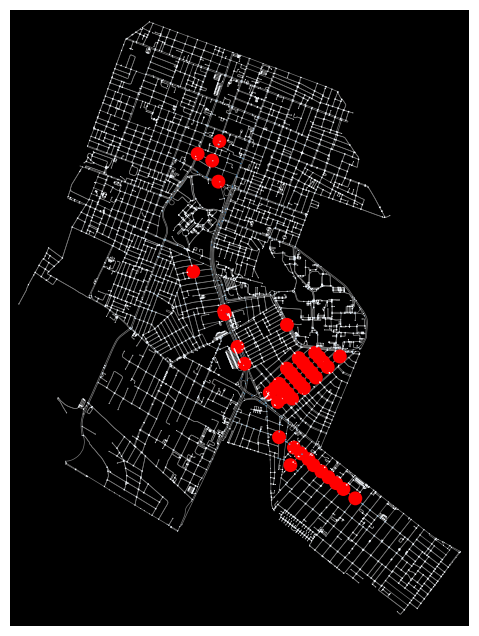

In [ ]:
cmap = plt.colormaps["Blues"]
norm = mcolors.Normalize(vmin=min(betweenness_centrality.values()), vmax=max(betweenness_centrality.values()))

# Definir a cor dos nós: nós sugeridos em vermelho, os demais variando de acordo com centralidade
node_color = ["red" if node in top_node_ids else cmap(norm(betweenness_centrality[node])) for node in G.nodes()]
node_size = [100 if node in top_node_ids else degree_centrality[node] * 1000 for node in G.nodes()]

# Plotar o grafo destacando os nós sugeridos em vermelho
fig, ax = ox.plot_graph(
    G, node_color=node_color, node_size=node_size,
    node_zorder=2, edge_linewidth=0.5, edge_color="#777777", bgcolor="black"
)


# 8. Calcular e plotar o PDF e CDF dos graus dos nós

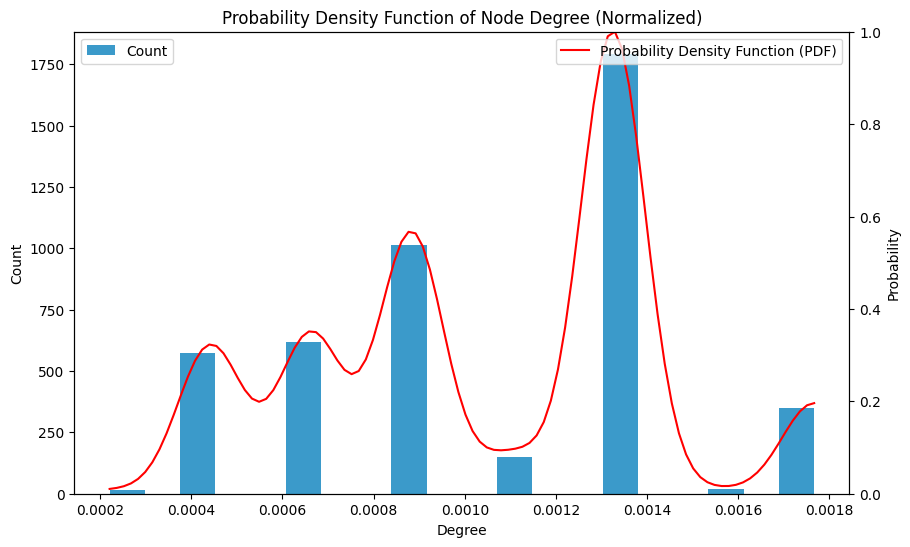

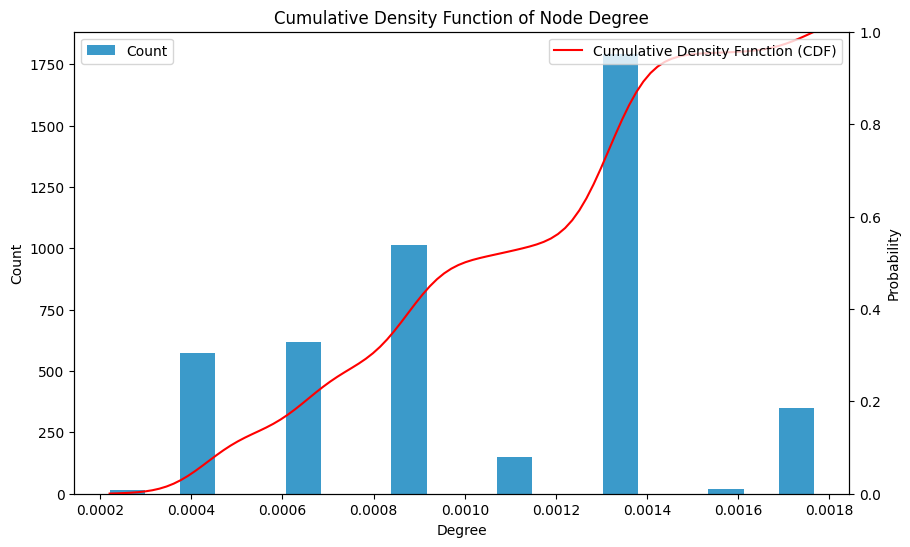

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Calcular a função densidade de probabilidade (PDF)
density = gaussian_kde(list(degree_centrality.values()))
x_grid = np.linspace(min(degree_centrality.values()), max(degree_centrality.values()), 100)
pdf = density(x_grid)

# Normalizar a PDF para o intervalo [0, 1]
pdf_normalized = pdf / np.max(pdf)

# Calcular a função densidade acumulada (CDF)
cdf = np.cumsum(pdf_normalized) / np.sum(pdf_normalized)

# Criar o gráfico para a PDF
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotar o count no eixo primário
counts, bins = np.histogram(list(degree_centrality.values()), bins=20)
ax1.hist(list(degree_centrality.values()), bins=bins, color='#258FC5', alpha=0.9, label='Count')
ax1.set_xlabel("Degree")
ax1.set_ylabel("Count", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

# Criar um eixo y secundário para a PDF normalizada
ax2 = ax1.twinx()
ax2.plot(x_grid, pdf_normalized, color='red', label='Probability Density Function (PDF)')
ax2.set_ylabel("Probability", color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0, 1)  # Define o limite para que a probabilidade vá de 0 a 1
ax2.legend(loc='upper right')

plt.title("Probability Density Function of Node Degree (Normalized)")
plt.show()

# Criar o gráfico para a CDF
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotar o count no eixo primário
ax1.hist(list(degree_centrality.values()), bins=bins, color='#258FC5', alpha=0.9, label='Count')
ax1.set_xlabel("Degree")
ax1.set_ylabel("Count", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

# Criar um eixo y secundário para a CDF
ax2 = ax1.twinx()
ax2.plot(x_grid, cdf, color='red', label='Cumulative Density Function (CDF)')
ax2.set_ylabel("Probability", color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0, 1)  # Garante que a CDF vá de 0 a 1
ax2.legend(loc='upper right')

plt.title("Cumulative Density Function of Node Degree")
plt.show()

# 9. Análise Multivariada das Métricas de Centralidade

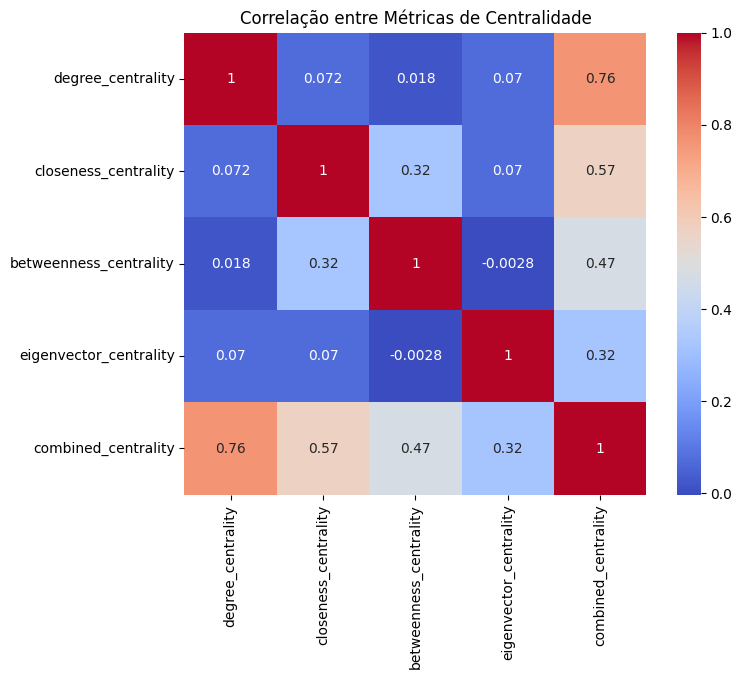

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.drop(columns=["Node"]).corr(), annot=True, cmap="coolwarm", square=True)
plt.title("Correlação entre Métricas de Centralidade")
plt.show()

# 10. Identificar o núcleo da rede usando k-core

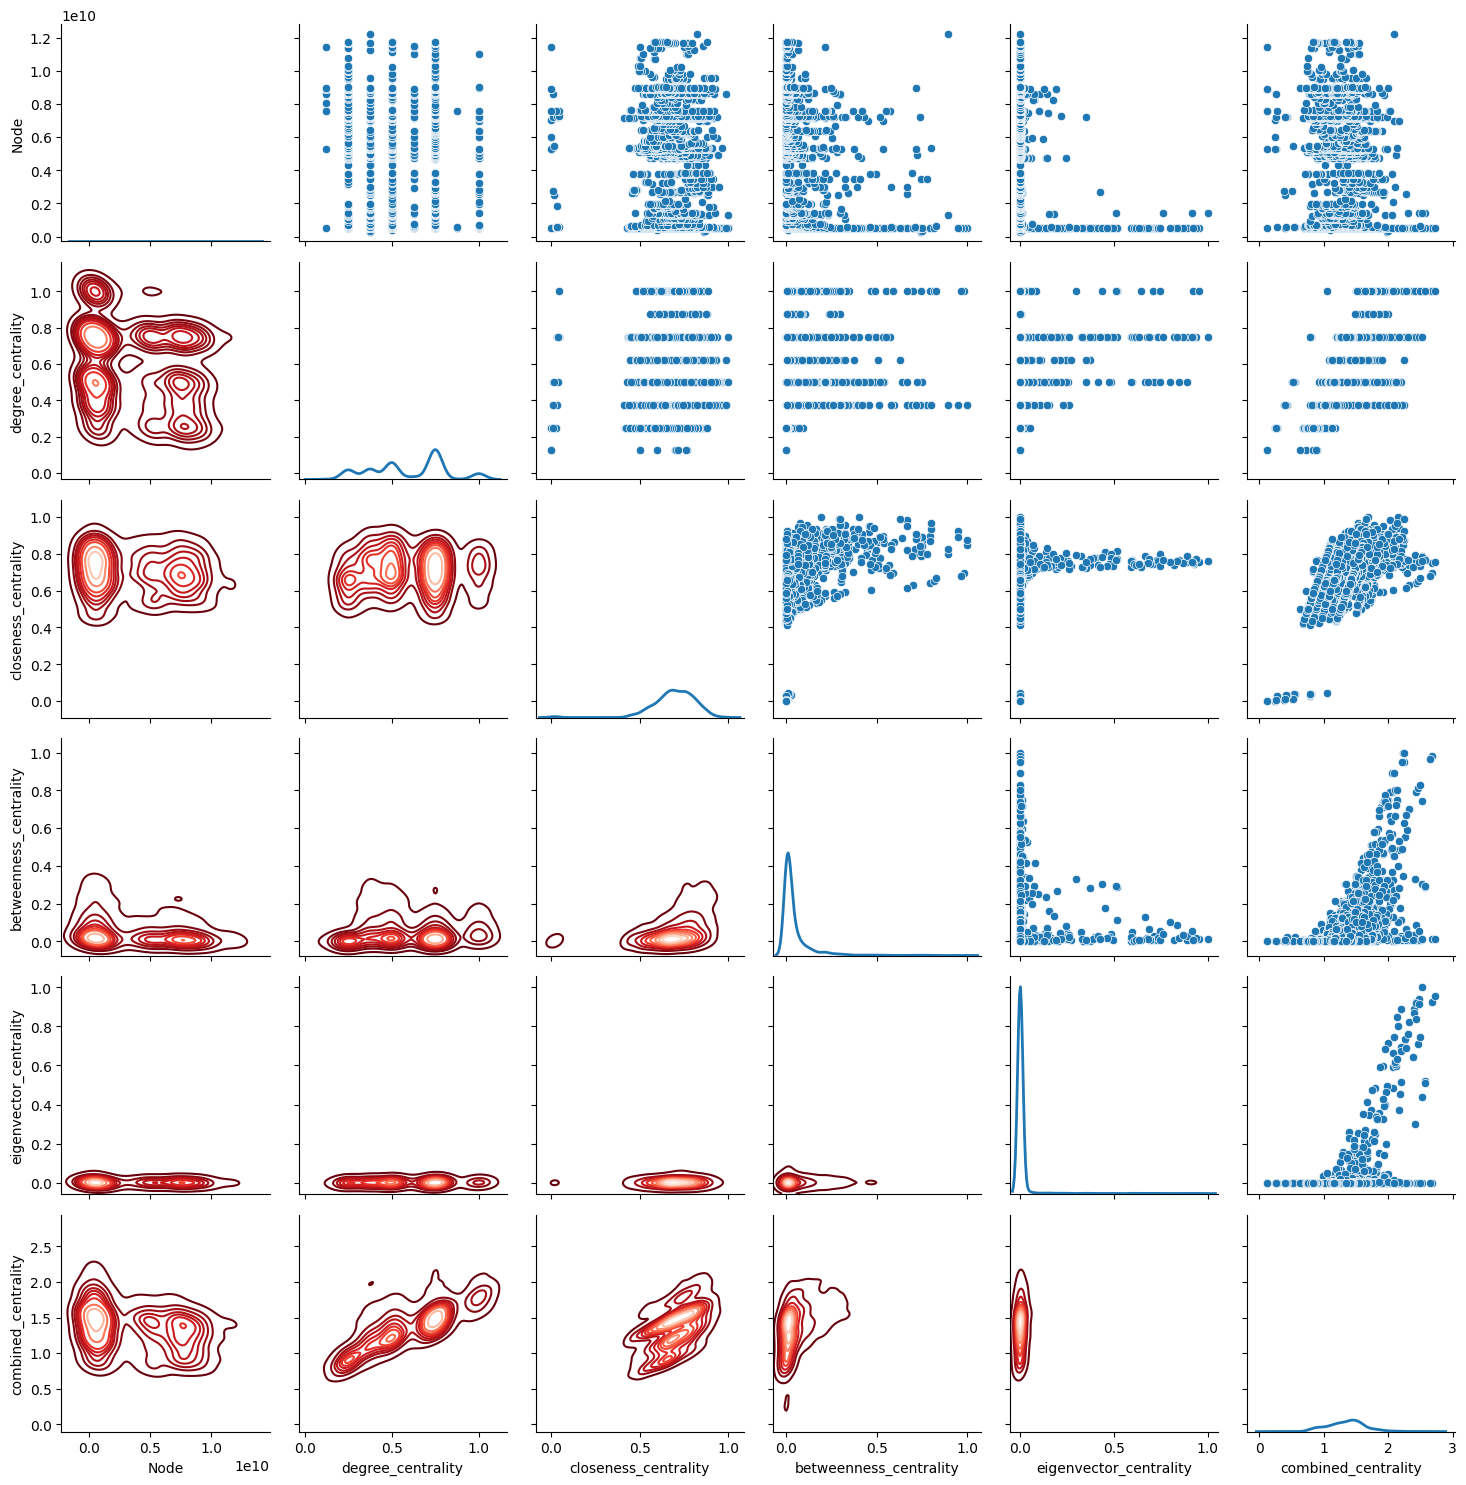

In [ ]:
fig = sns.PairGrid(df)
fig.map_upper(sns.scatterplot)
fig.map_lower(sns.kdeplot, cmap="Reds_r")
fig.map_diag(sns.kdeplot, lw=2, legend=False)

In [ ]:
# prompt:  how many k-cores does this network have?

# Convert MultiDiGraph to a simple undirected graph
G_undirected = nx.Graph(G)

# Remove self-loops from the undirected graph
G_undirected.remove_edges_from(nx.selfloop_edges(G_undirected)) #This line removes self loops

# Calculate k-core decomposition
k_cores = nx.core_number(G_undirected)

# Find the maximum k-core value
max_k = max(k_cores.values())

print(f"The network has k-cores up to k = {max_k}")

set([v for k,v in nx.core_number(G_undirected).items()])

The network has k-cores up to k = 2


{1, 2}

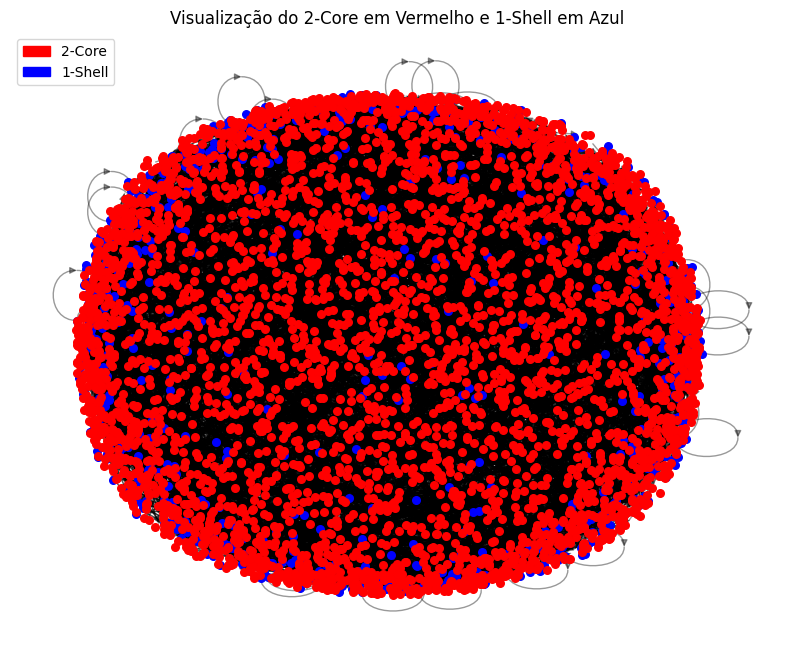

In [ ]:
import matplotlib.patches as mpatches

# Calcular o k-core e k-shell usando nx.k_core e nx.k_shell
G_k_core = nx.k_core(G_undirected, k=max_k)
G_k_shell = nx.k_shell(G_undirected, k=max_k-1)

# Configurar o layout fixo para a visualização
pos = nx.spring_layout(G, seed=42, k=0.3)

# Criar a figura
fig, ax = plt.subplots(figsize=(10, 8))

# Desenhar as arestas para contexto
nx.draw_networkx_edges(G, pos=pos, alpha=0.4, ax=ax)

# Desenhar os nós com cores específicas: 2-core em vermelho, 1-shell em azul, e o restante em preto
nx.draw_networkx_nodes(G, pos=pos, node_color="#333333", node_size=10, alpha=0.3)  # Outros nós em preto
nx.draw_networkx_nodes(G_k_shell, pos=pos, node_color="blue", node_size=30, label=f"{max_k-1}-Shell")  # 1-shell em azul
nx.draw_networkx_nodes(G_k_core, pos=pos, node_color="red", node_size=30, label=f"{max_k}-Core")  # 2-core em vermelho

# Legenda fixa para as cores dos nós
red_patch = mpatches.Patch(color='red', label=f'{max_k}-Core')
blue_patch = mpatches.Patch(color='blue', label=f'{max_k-1}-Shell')
plt.legend(handles=[red_patch, blue_patch], loc="upper left")

plt.axis("off")
plt.title(f"Visualização do {max_k}-Core em Vermelho e {max_k-1}-Shell em Azul")
plt.show()

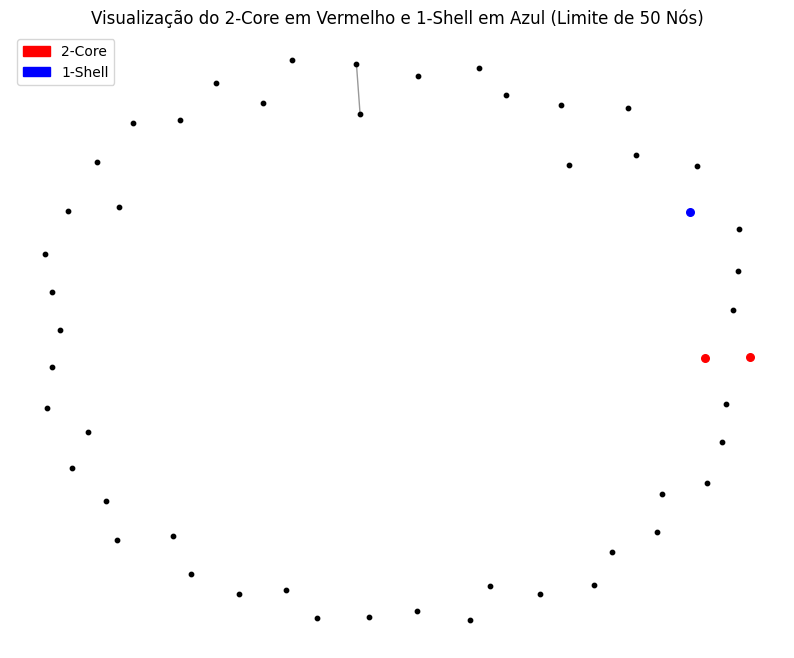

In [ ]:
import matplotlib.patches as mpatches
import networkx as nx
import matplotlib.pyplot as plt
import random

# Calcular o k-core e k-shell usando nx.k_core e nx.k_shell
G_k_core = nx.k_core(G_undirected, k=max_k)
G_k_shell = nx.k_shell(G_undirected, k=max_k-1)

# Selecionar exatamente os nós dos subgrafos desejados
nodes_k_core = list(G_k_core.nodes())[:max_k]  # Seleciona exatamente max_k nós para o k-core
nodes_k_shell = list(G_k_shell.nodes())[:max_k-1]  # Seleciona exatamente max_k-1 nós para o k-shell

# Combinar e limitar o grafo principal a 50 nós, incluindo os nós do k-core e k-shell
all_nodes = set(nodes_k_core + nodes_k_shell)  # Garantir que os nós de interesse estejam incluídos
remaining_nodes = [n for n in G_undirected if n not in all_nodes]
random_nodes = random.sample(remaining_nodes, max(0, 50 - len(all_nodes)))  # Completa até 50 nós se necessário

# Criação de subgrafo limitado a 50 nós
G_limited = G_undirected.subgraph(list(all_nodes) + random_nodes)

# Configurar o layout fixo para a visualização
pos = nx.spring_layout(G_limited, seed=42, k=0.3)

# Criar a figura
fig, ax = plt.subplots(figsize=(10, 8))

# Desenhar as arestas para contexto
nx.draw_networkx_edges(G_limited, pos=pos, alpha=0.4, ax=ax)

# Desenhar os nós com cores específicas
# Nós restantes em preto (contexto)
nx.draw_networkx_nodes(G_limited, pos=pos,
                       nodelist=[n for n in G_limited if n not in nodes_k_core and n not in nodes_k_shell],
                       node_color="black", node_size=10, alpha=1)
# k-shell em azul
nx.draw_networkx_nodes(G_limited, pos=pos, nodelist=nodes_k_shell, node_color="blue", node_size=30, label=f"{max_k-1}-Shell")
# k-core em vermelho
nx.draw_networkx_nodes(G_limited, pos=pos, nodelist=nodes_k_core, node_color="red", node_size=30, label=f"{max_k}-Core")

# Legenda fixa para as cores dos nós
red_patch = mpatches.Patch(color='red', label=f'{max_k}-Core')
blue_patch = mpatches.Patch(color='blue', label=f'{max_k-1}-Shell')
plt.legend(handles=[red_patch, blue_patch], loc="upper left")

plt.axis("off")
plt.title(f"Visualização do {max_k}-Core em Vermelho e {max_k-1}-Shell em Azul (Limite de 50 Nós)")
plt.show()
